<a href="https://colab.research.google.com/github/namper/DeepLearning/blob/master/color_labeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
# Imports
import os
import torch
import numpy as np
from torch import nn
from PIL import Image
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision import datasets, transforms, models

In [171]:
%rm -r GEN_DATA

rm: cannot remove 'GEN_DATA': No such file or directory


In [179]:
# GENERATE DATA

if not os.path.exists('GEN_DATA'):
  os.mkdir('GEN_DATA')
base_path = 'GEN_DATA/'

def generate_color_range(red, green, blue):
  return [(r, g, b) for r in red for g in green for b in blue]

color_factory = {
    'red': generate_color_range(red=range(115, 255, 10), blue=range(0, 50, 10), green=range(0, 50, 10)),
    'green': generate_color_range(green=range(115, 255, 10), blue=range(0, 50, 10), red=range(0, 50, 10)),
    'blue': generate_color_range(blue=range(115, 255, 10), red=range(0, 50, 10), green=range(0, 50, 10)),
}
for color, factory in color_factory.items():
  path = f'{base_path}/{color}'
  if not os.path.exists(path):
    os.mkdir(path)
  for ord, colour in enumerate(factory):
    img = Image.new('RGB', (200, 200), colour)
    img.save(f'{path}/{color}_{ord}.jpeg')

In [102]:
# Check GPU - ON 
device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
device

device(type='cuda')

In [135]:
# Spit Data To Train, Test Data And Retrieve Random Sample

from torch.utils.data.sampler import SubsetRandomSampler
VALIDATION_SIZE = 0.2

# transformation for images
transform = transforms.Compose([transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])


train_data = datasets.ImageFolder('GEN_DATA', transform=transform)
test_data = datasets.ImageFolder('GEN_DATA', transform=transform)

# split by random shuffling 
data_len = len(train_data)

indicies = list(range(data_len))
np.random.shuffle(indicies)

split_at = int(np.floor(VALIDATION_SIZE * data_len))
test_ids, train_ids = indicies[: split_at], indicies[split_at:]

train_loader = torch.utils.data.DataLoader(train_data, sampler=SubsetRandomSampler(train_ids), batch_size=64)
test_loader = torch.utils.data.DataLoader(test_data, sampler=SubsetRandomSampler(test_ids), batch_size=64)

classes = train_loader.dataset.classes
classes

['blue', 'green', 'red']

In [183]:
# Freeze The Pre-Trained Layers And Add Fully Connected Layer To Train Images

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False
    
model.fc = nn.Sequential(
    # nn.Conv2d(512, 256, )
    nn.Linear(512, 256),
    nn.ReLU(),
    nn.Dropout(0.2),
    nn.Linear(256, 3),
    nn.LogSoftmax(dim=1)
)
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.003)
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [184]:
# Train & Display

epochs = 2
steps = 0
running_loss = 0
print_every = 10
train_losses, test_losses = [], []
for epoch in range(epochs):
    for inputs, labels in train_loader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += \
                   torch.mean(equals.type(torch.FloatTensor)).item()
            train_losses.append(running_loss/len(train_loader))
            test_losses.append(test_loss/len(test_loader))

            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(test_loader):.3f}.. "
                  f"Test accuracy: {accuracy/len(test_loader):.3f}")
            running_loss = 0
            model.train()
torch.save(model, 'colour.pth')

Epoch 1/2.. Train loss: 0.353.. Test loss: 0.528.. Test accuracy: 0.729
Epoch 2/2.. Train loss: 0.038.. Test loss: 0.064.. Test accuracy: 0.968


In [185]:
# Test Generalization
model = torch.load('colour.pth')
model.eval()

def predict_image(image):
  image_tensor = transform(image).float()
  image_tensor = image_tensor.unsqueeze_(0)
  input = Variable(image_tensor)
  input = input.to(device)
  output = model(input)
  index = output.data.cpu().numpy().argmax()
  return index

0 blue


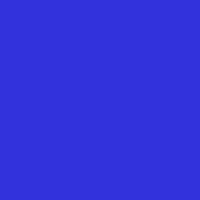

In [211]:
# COLOUR = 'blue'

# colors = [Image.open(f'DATA/{COLOUR}/'+image) for image in os.listdir(f'DATA/{COLOUR}')]
# for color in colors:
#   prediction = classes[predict_image(color)]
#   print(prediction, prediction == COLOUR)


red = (50, 50, 220)
im = Image.new('RGB', (200, 200), red)
# Image.open('DATA/red/red.jpg')
prediction = predict_image(im)
print(prediction, classes[prediction])
im